In [1]:
import numpy as np

from hps.pdo               import PDO2d,PDO3d,const,get_known_greens
from hps.geom              import BoxGeometry, ParametrizedGeometry2D,ParametrizedGeometry3D

from hps.hps_multidomain   import HPSMultidomain
from hps.fd_discretization import FDDiscretization
from matplotlib            import pyplot as plt

## Solving the Helmholtz Equation on a Curved Domain

We aim to solve the **Helmholtz equation** on a *curved domain* denoted by $\Psi$. 
$$
-\Delta u(x) - \kappa^2 u(x) = f(x), \quad x \in \Psi,
$$
with appropriate boundary conditions.

However, instead of working directly on $\Psi$, we are provided with numerical tools that solve **variable-coefficient elliptic partial differential equations (PDEs)** on a simpler, **reference domain** $\Omega$. In our case, $\Omega$ is the unit square.

To bridge the gap between these two domains, we define **smooth bijective maps** that allow us to convert between the reference and physical (curved) domains. These mappings enable us to transform the problem from the complex geometry of $\Psi$ to the more manageable geometry of $\Omega$.

### Domain Definitions

- **Reference Domain**: $\Omega$ (unit square)
- **Physical/Curved Domain**: $\Psi$

### Mappings Between Domains

Let us define two smooth mappings:

- $y: \Psi \rightarrow \Omega$  
  This mapping takes a point from physical domain $\Psi$ and maps it to the reference domain $\Omega$.

- $z: \Omega \rightarrow \Psi$  
  This mapping takes a point from reference domain $\Omega$ and maps it to the physical domain $\Psi$.


These maps are assumed to be smooth and invertible, satisfying:
$$
y(z(x)) = x, \quad \forall x \in \Psi.
$$

### Variable Coefficient PDE

To write this explicitly, suppose a point in the curved domain $\Psi$ with coordinates $(x_1, x_2)$ is mapped to a point in the reference domain $\Omega$ with coordinates $(y_1, y_2)$. This inverse mapping is defined by two smooth functions:

$$
y_1 = y_1(x_1, x_2), \quad y_2 = y_2(x_1, x_2)
$$

That is, each coordinate in the reference domain depends on the position in the curved domain.
Then the transformed equation on the reference domain becomes:

$$
\left( \frac{\partial}{\partial x_1} + \frac{\partial}{\partial x_2} \right) {u}(y_1(x_1, x_2), y_2(x_1, x_2)) = f(y_1(x_1, x_2), y_2(x_1, x_2)), \quad (y_1, y_2) \in \Omega,
$$
with appropriate boundary conditions.

Note: In practice, derivatives with respect to $x_1$ and $x_2$ must be expressed in terms of derivatives with respect to $y_1$ and $y_2$ using the chain rule and the Jacobian matrix of the transformation.

In [2]:
#############################################################
### Function z maps from reference domain (square) to curved domain
mag    = 0.25
psi    = lambda z: 1 - mag * np.sin(6*z)

z1   = lambda xx: xx[:,0]
z2   = lambda xx: np.divide(xx[:,1],psi(xx[:,0]))

### Function y is the inverse map
y1   = lambda xx: xx[:,0]
y2   = lambda xx: np.multiply(xx[:,1],psi(xx[:,0]))

### We compute partial derivatives with respect to y.
### Some of them are zero and omitted.

dpsi   = lambda z:   - mag*6 * np.cos(6*z)
ddpsi  = lambda z:     mag*36  * np.sin(6*z)

y1_d1  = lambda xx: np.ones(xx[:,0].shape)
y2_d1  = lambda xx: np.multiply(xx[:,1], dpsi(xx[:,0]))
y2_d2  = lambda xx: psi(xx[:,0])

y2_d1d1= lambda xx: np.multiply(xx[:,1], ddpsi(xx[:,0]))

## Interface for solving with HPS

For the Helmholtz equation, I've tried to make the interface easy to use, and swept the details into convenient classes. Given the definitions of $y$ and $z$ above as well as relevant partial derivatives with respect to $y$, solving the PDE on the physical geometry can be done as such.

In [3]:
# We define the reference geometry.
box_geom   = np.array([[0,0],[1.0,1.0]])

# The parametrized geometry is defined by reference,
# the maps y and z as well as partial derivatives wrt y.

param_geom = ParametrizedGeometry2D(box_geom, z1, z2, y1, y2,\
    y1_d1=y1_d1, y2_d1=y2_d1, y2_d2=y2_d2,y2_d1d1=y2_d1d1)

a = 1/8; p = 10 # discretization parameters
kh = 0          # wavenumber

### The bfield defines the coefficient on the PHYSICAL domain.
### You can add a variable coefficient (obstacle) if you wish in the PHYSICAL domain.
def bfield_constant(xx,kh):
    return -(kh**2) * np.ones(xx.shape[0])

### Here, it is transformed to a variable-coefficient PDE on the reference.
pdo_mod = param_geom.transform_helmholtz_pdo(bfield_constant, kh)

### To interface with the solver, plug the MODIFIED pde and the parameterized
### geometry class into the usual HPSMultidomain interface.
solver  = HPSMultidomain(pdo_mod,param_geom,a,p)
relerr  = solver.verify_discretization(kh)
print("relerror in 2D curved domain %5.2e" % relerr)

relerror in 2D curved domain 3.72e-10


## Collocation points on reference and physical domains

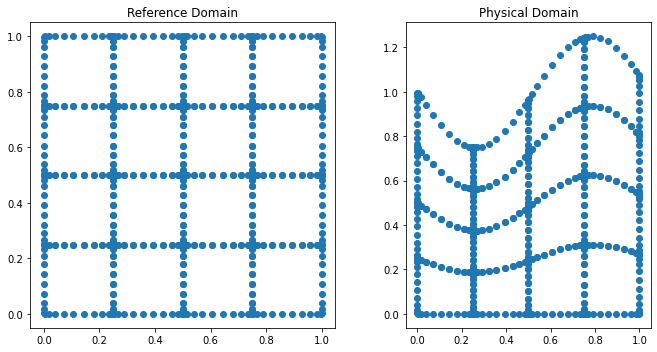

In [4]:
points_reference = solver.XX
points_physical  = np.vstack((y1(solver.XX),y2(solver.XX))).T

# Create side-by-side scatter plots with equal aspect ratios
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot: Reference Domain
axes[0].scatter(points_reference[:, 0], points_reference[:, 1])
axes[0].set_title("Reference Domain")
axes[0].set_aspect('equal')

# Plot: Physical Domain
axes[1].scatter(points_physical[:, 0], points_physical[:, 1])
axes[1].set_title("Physical Domain")
axes[1].set_aspect('equal')

# Layout
plt.tight_layout()
plt.show()